In [1]:
""" Script to grow sea ice with varying air temperature and snow depth
Contributions:
A. Mahoney(University of Alaska Fairbanks): original 1D excel model for growing sea ice with constant temperature/snow-depth/freezing point
J. Shates (University of Wisconsin-Madison): initial translation from excel to python, data discovery and processing met data, precip to snow depth 
O. Baadshaug (Univeristy of Tromsoe): updates to sea ice function, handling nans and inputting hourly data 
J. Lohse (University of Tromsoe): converting daily snow depth values to hourly values
N. Ochwat (Univerity of Calgary): using model to determine date of sediment entrainment found in ice core

hourly met data:
in-situ hourly temperature & wind measurements: https://www.esrl.noaa.gov/gmd/dv/iadv/
site information: https://www.esrl.noaa.gov/gmd/obop/brw/

daily precip data: http://climate.gi.alaska.edu/acis_data
documentation: http://www.rcc-acis.org/docs_datasets.html

snow density measurements taken at 71 17'18.8"N 156 29'34.5"W
"""
from update2_sea_ice import Grow_Ice
from update2_sea_ice import Remove_bad_values
from snowfall_functions import get_snowdepth
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pickle
import calendar
import pandas as pd

##### load in temperature (hourly), precip(daily->altered to hourly in the script) 
# -999.9= missing value for temperature
#files are in .p form 

ymdh = pickle.load( open( "YMDH.p", "rb" ) )
temp10m = pickle.load( open( "TEMP10M.p", "rb" ) )
temp2m = pickle.load( open( "TEMP2M.p", "rb" ) )
PRECIP = pickle.load( open( "DAILY_PRECIP.p", "rb" ) )
precip=np.array(PRECIP[14:])

YMDH = []
for i in ymdh:
    YMDH.append(datetime.strptime(i, '%Y%m%d%H'))

first_indx = np.where(ymdh == '2017101500')[0][0]
last_indx = np.where(ymdh == '2018040101')[0][0]

Ta=temp2m[first_indx:last_indx]

Dates=YMDH[first_indx:last_indx]

"""Use function Remove_bad_values to get rid of the missing data from the temperature file;
missing values from precip data is handled separately in get_snowdepth function"""

Ta=Remove_bad_values(Ta, -999.9) #treat the -999.9 as a NAN
daily=get_snowdepth(precip) #daily is an np array

"""This loops gets the daily snow depth and adjusts it to be hourly
The following code can handle any missing snow depth values and fill in with the previous snow depth 
(This was an issue that is now already handled in the get_snowdepth function)
"""

for i,day in enumerate(daily):
     if i==0:
         hourly_tmp = np.ones((1,24))
         hourly = np.ones((1,24))
         hourly[:] = daily[i]

     else:    
         hourly_tmp_old = hourly_tmp

         if daily[i]==0:
            hourly_tmp = hourly_tmp_old
         else:
             hourly_tmp[:]=daily[i]

         hourly = np.vstack((hourly,hourly_tmp))

HS=np.ravel(hourly)

HS_final=HS[-1] 
#final value of snow depth for sanity check
print('Final snow depth over the ice: %f' %HS_final)

Dt_days = 1./24. #since we're working with houlry data, each delta time is 1/24 of a day

Fw=0. #starting with no residual heat flux

##USE GROW ICE FUNCTION :) 
[Hi,hours] = Grow_Ice(Ta,HS,Fw,Dt_days)
dates=[Dates[j] for j in hours]
print('Final ice thickness: %f' %Hi[-1])

month1=calendar.month_abbr[10]
year1='2017'

month2=calendar.month_abbr[4]
year2='2018'



Final snow depth over the ice: 0.178424
Final ice thickness: 1.474613


In [2]:
"""Adust the forcing in the model to have a 4W/m2 ocean heat flux """
Fw = 4.


[Hi,hours] = Grow_Ice(Ta,HS,Fw,Dt_days)
dates=[Dates[j] for j in hours]
print('Hi_F4n')
print('Final ice thickness: %f' %Hi[-1])
HS_final=HS[-1] 

print('Final snow depth over the ice: %f' %HS_final)

month1=calendar.month_abbr[10]
year1='2017'

month2=calendar.month_abbr[4]
year2='2018'

Hi_F4n=Hi

Hi_F4n
Final ice thickness: 1.355983
Final snow depth over the ice: 0.178424


In [3]:
"""Adust the forcing in the model to have a 10W/m2 ocean heat flux"""
Fw = 10.

Dt_days = 1./24.

[Hi,hours] = Grow_Ice(Ta,HS,Fw,Dt_days)
dates=[Dates[j] for j in hours]
print('Hi_F10n')
print('Final ice thickness: %f' %Hi[-1])
HS_final=HS[-1] 

print('Final snow depth over the ice: %f' %HS_final)

month1=calendar.month_abbr[10]
year1='2017'

month2=calendar.month_abbr[4]
year2='2018'

Hi_F10n=Hi

Hi_F10n
Final ice thickness: 1.187338
Final snow depth over the ice: 0.178424


In [4]:
"""Adust the forcing in the model to have a 4W/m2 ocean heat flux and double the snow depth at all time steps"""
Fw = 4.
HS = 2*HS

Dt_days = 1./24.


[Hi,hours] = Grow_Ice(Ta,HS,Fw,Dt_days)
dates=[Dates[j] for j in hours]
print('Hi_F4_2xn')
print('Final ice thickness: %f' %Hi[-1])
HS_final=HS[-1] 

print('Final snow depth over the ice: %f' %HS_final)

month1=calendar.month_abbr[10]
year1='2017'

month2=calendar.month_abbr[4]
year2='2018'

Hi_F4_2x=Hi

Hi_F4_2xn
Final ice thickness: 1.175725
Final snow depth over the ice: 0.356849


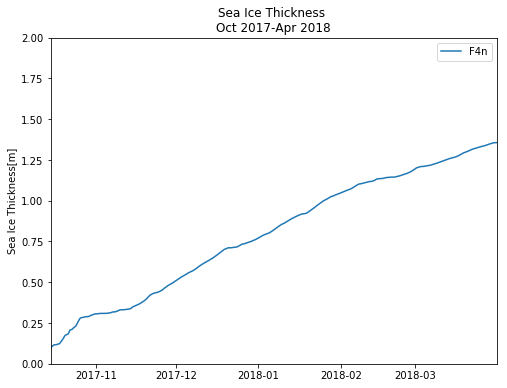

In [5]:
"""
plots for forcing:
4W/m2 forcing of ocean heatflux
no adjustments to precip
"""
fig=plt.figure(figsize=([8,6]))
ax = fig.add_subplot(111)
ax.plot(dates[1:],Hi_F4n[1:])# ax.plot(np.arange(len(Ta)+1), Hi)


plt.ylabel('Sea Ice Thickness[m]')
titlestring='Sea Ice Thickness \n' + month1 +' '+ year1 +'-'+ month2+' '+year2
plt.title(titlestring)
plt.xlim((dates[0],dates[-1]))
plt.ylim(0, 2)
#plt.savefig('SEA_ICE_1.png')
plt.legend(['F4n'])
plt.show(block=True)

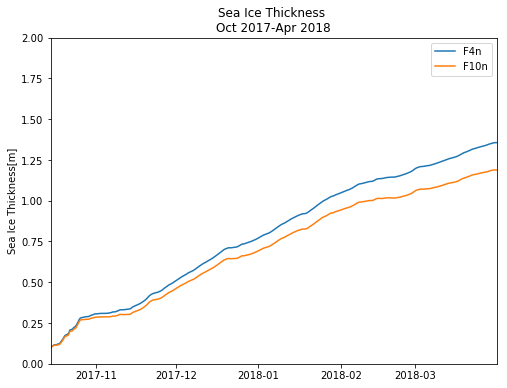

In [15]:
"""
plots for 2 forcings:
4W/m2 forcing of ocean heatflux
no adjustments to precip
"""
fig=plt.figure(figsize=([8,6]))
ax = fig.add_subplot(111)
ax.plot(dates[1:],Hi_F4n[1:])
ax.plot(dates[1:],Hi_F10n[1:])# ax.plot(np.arange(len(Ta)+1), Hi)


plt.ylabel('Sea Ice Thickness[m]')
titlestring='Sea Ice Thickness \n' + month1 +' '+ year1 +'-'+ month2+' '+year2
plt.title(titlestring)
plt.xlim((dates[0],dates[-1]))
plt.ylim(0, 2)
#plt.savefig('SEA_ICE_2.png')
plt.legend(['F4n','F10n'])
plt.show(block=True)

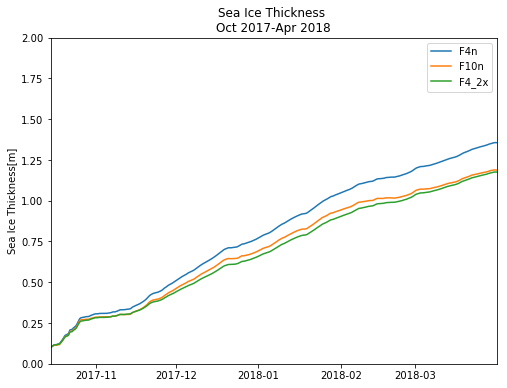

In [6]:
"""
plots for 3 forcings:
4W/m2 forcing of ocean heatflux
no adjustments to precip
"""
fig=plt.figure(figsize=([8,6]))
ax = fig.add_subplot(111)
ax.plot(dates[1:],Hi_F4n[1:])
ax.plot(dates[1:],Hi_F10n[1:])
ax.plot(dates[1:],Hi_F4_2x[1:])# ax.plot(np.arange(len(Ta)+1), Hi)


plt.ylabel('Sea Ice Thickness[m]')
titlestring='Sea Ice Thickness \n' + month1 +' '+ year1 +'-'+ month2+' '+year2
plt.title(titlestring)
plt.xlim((dates[0],dates[-1]))
plt.ylim(0, 2)
#plt.savefig('SEA_ICE_3.png')
plt.legend(['F4n','F10n','F4_2x'])
plt.show(block=True)